In [152]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [154]:
words = open('names.txt','r').read().splitlines()
#lowercase and remove unnecessary characters
words = [name.strip().lower() for name in words if name.strip()]
words = [w.replace('.', '').replace(',', '').replace('(', '').replace(')', '').replace('-', '') for w in words]

random.seed(42)
random.shuffle(words)

In [156]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [158]:
block_size = 8
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [253]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

    def __init__(self,n):
        self.n = n

    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers = layers
        
    def __call__(self,x):
        
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]





In [258]:
torch.manual_seed(42)

In [284]:
n_embd = 18 
n_hidden = 100


model = Sequential([
  Embedding(vocab_size,n_embd),
  FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True









47413


In [286]:
max_steps = 100000
batch_size = 35
lossi = []


for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)
  
  
  
  
  for p in parameters:
    p.grad = None
  loss.backward()
  
  
  lr = 0.1 if i < 70000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: 
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 100000: 3.6459
  10000/ 100000: 2.0922
  20000/ 100000: 1.8005
  30000/ 100000: 1.7363
  40000/ 100000: 1.4171
  50000/ 100000: 1.7648
  60000/ 100000: 1.7726
  70000/ 100000: 2.0707
  80000/ 100000: 1.7567
  90000/ 100000: 1.4599


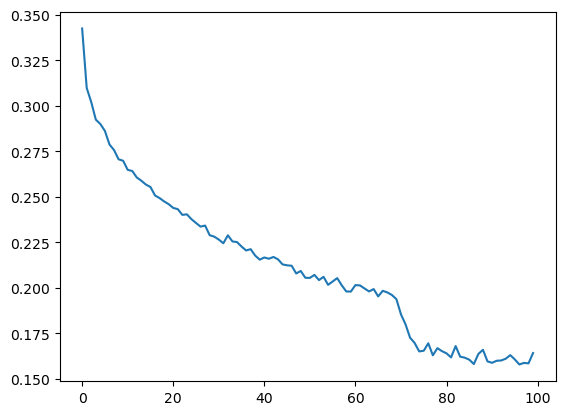

In [288]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [290]:
for layer in model.layers:
    layer.training = False

In [292]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.4020310640335083
val 2.0646369457244873


In [294]:
#sampling from model
g = torch.Generator().manual_seed(2147483647 + 10)

f = open('sampled_examples.txt','w')

for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
  
      context = context[1:] + [ix]
      out.append(ix)

      if ix == 0:
        break

    output_word = ''.join(itos[i] for i in out)
    print(output_word)
    f.write(output_word+'\n')
      
        
    
f.close()

britam.
sajung.
swed.
riksan.
suruchi.
rajkumi.
jenita.
ishwary.
alekh.
susmina.
samyukti.
kripa.
shubhagya.
minesh.
nirwan.
shubhekch.
utkarsha.
samyuj.
mhohana.
sushmita.


In [183]:
e = torch.randn(4,8,10)
torch.cat([e[:, ::2, :],e[:,1::2,:]],dim=2).shape

torch.Size([4, 4, 20])

In [191]:
(e.view(4,4,20) == torch.cat([e[:, ::2, :],e[:,1::2,:]],dim=2)).all()

tensor(True)